In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filename = 'top_500.csv'
file = f'../data/01_raw/{filename}'

try:
    data = pd.read_csv(file)
    print(f"Plik '{file}' został poprawnie wczytany.")
except Exception as e:
    print(f"Błąd podczas wczytywania pliku: {e}")
    data = pd.DataFrame()

In [ ]:
# Podstawowe informacje o danych
info = pd.DataFrame({
    'Typ kolumny': data.dtypes,
    'Brakujące wartości': data.isnull().sum(),
    'Unikalne wartości': data.nunique()
})

print(f"Rozmiar danych: {data.shape[0]} wierszy × {data.shape[1]} kolumn\n")
display(info)

In [ ]:
# Rozkład cech numerycznych

# Ustawienia wyświetlania
sns.set_theme(style="whitegrid")

# Kolumny z wartościami numerycznymi
all_num_cols = data.select_dtypes(include=['int64', 'float64']).columns
print("Kolumny z wartościami numerycznymi:")
print(list(all_num_cols))

# Histogram ceny
data["price"].plot(kind="hist", bins=40, title="Rozkład ceny gier", figsize=(8, 5))
plt.xlabel("Cena")
plt.ylabel("Liczba gier")
plt.show()

# Liczba gier na poszczególne platformy
data[["windows", "mac", "linux"]].sum().plot(kind="bar", title="Dostępność na platformach", rot=0)
plt.ylabel("Liczba gier")
plt.show()

# Liczba gier w poszczególnych latach
pd.to_datetime(data["release_date"], errors="coerce").dt.year.value_counts().sort_index().plot(kind="bar", figsize=(12, 5))
plt.title("Liczba gier wydanych w poszczególnych latach")
plt.xlabel("Rok")
plt.ylabel("Liczba gier")
plt.show()

# Rozkład pozytywnych recenzji
sns.histplot(data['pct_pos_total'], bins=20, kde=True)
plt.title("Rozkład procenta pozytywnych recenzji (ogółem)")
plt.show()

In [ ]:
# Rozkład cech kategorycznych 

# Kolumny kategoryczne sensowne do analizy
cat_cols = ['release_date', 'genres', 'categories', 'tags']

for col in cat_cols:
    if col not in data.columns:
        continue  # pomijamy kolumny, których nie ma w danych

    # Kolumny typu lista do rozbicia i zliczenia
    # Niektóre kolumny mają zapis w typie string z listą, np. "['Action', 'Adventure']" przez to, że gra mieści się np. w wielu genrach
    if col in ['genres', 'categories', 'tags', 'platforms', 'steamspy_tags']:
        exploded = (data[col]
                    .dropna()
                    .apply(lambda x: eval(x) if isinstance(x, str) else x)
                    .explode())
        counts = exploded.value_counts()
    else:
        # Zwykłe kolumny w typie string
        counts = data[col].value_counts()

    # Kategorie zliczane, które warto przedstawić w zestawieniu Najczęściej występujących
    if len(counts) > 10:
        top_counts = counts[:10]
        # top_counts['Pozostałe'] = counts[10:].sum()
        plot_data = top_counts
        title = f"Top 10 : {col}"
    else:
        plot_data = counts
        title = f"Rozkład kategorii dla {col}"

    plt.figure(figsize=(10, 5))
    plot_data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Liczba wystąpień')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Wstępna Agregacja danych i określenie targetu

# Usunięcie kolumn gdzie jest więcej niż 30% pustych wierszy
threshold = 0.3
for col in data.columns:
    missing_ratio = data[col].isnull().mean()
    if missing_ratio > threshold:
        print(f"[DROP] {col} (missing_ratio={missing_ratio:.2%})")
        data.drop(columns=col, inplace=True)

# Usunięcie kolumn positive i negative -> zapobieganie data leak
if {'positive', 'negative'}.issubset(data.columns):
    data.drop(columns=['positive', 'negative'], inplace=True)
    print("[DROP] columns=['positive', 'negative']")

# Enkodowanie danych kategorycznych

# Data wydania -> rok, miesiąc wydania.
if 'release_date' in data.columns:
    data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
    data['release_year'] = data['release_date'].dt.year
    data['release_month'] = data['release_date'].dt.month
    data.drop(columns=['release_date'], inplace=True)
    print("[ENCODE] release_date -> release_year, release_month")

# Dane kategoryczne na binarne -> int 0-1
bin_flag_cols = [
    'website', 'support_url', 'detailed_description', 'about_the_game', 'short_description',
    'header_image', 'screenshots', 'movies'
]
for col in bin_flag_cols:
    if col in data.columns:
        data[f"has_{col}"] = data[col].notnull().astype(int)
        data.drop(columns=[col], inplace=True)
        print(f"[ENCODE] {col} -> has_{col} (0/1)")

# Systemy operacyjne -> bool na int 0-1
platform_cols = ['windows', 'mac', 'linux']
for col in platform_cols:
    if col in data.columns:
        data[col] = data[col].fillna(False).astype(int)
        print(f"[CAST] {col}: bool -> int (0/1)")

# Usunięcie niepotrzebnych kolumn
drop_cols = [
    'num_reviews_recent',
    'pct_pos_recent',  # bardzo szybko są outdated, więc usuwamy
]

for col in drop_cols:
    if col in data.columns:
        data.drop(columns=[col], inplace=True)
        print(f"[DROP] {col}")

# TODO: zastanowić się jak to obrobić
#11  supported_languages       498 non-null    object
#12  full_audio_languages      498 non-null    object
#13  packages                  498 non-null    object
#14  developers                498 non-null    object
#15  publishers                498 non-null    object
#16  categories                498 non-null    object
#17  genres                    498 non-null    object
#18  estimated_owners

# % pozytywnych ocen -> nasz target -> 'pct_pos_total'

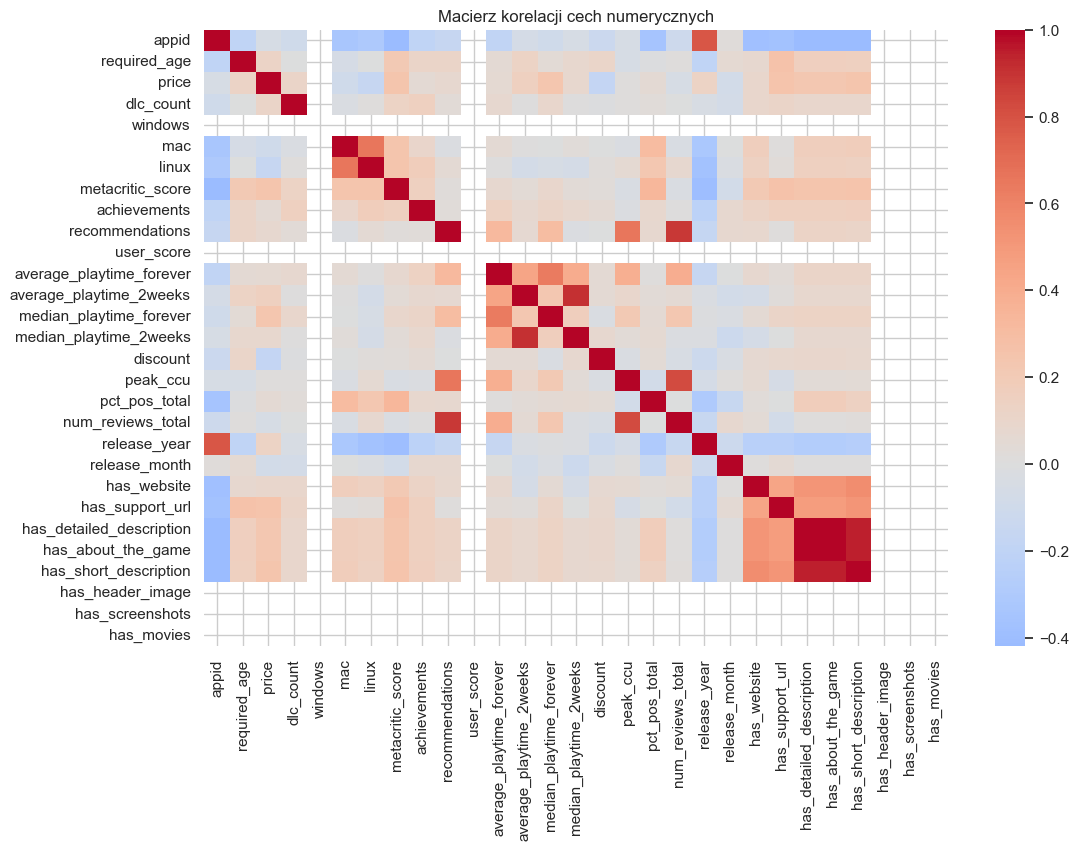

In [37]:
# Macierz korelacji
corr = data.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
    center=0,
)
plt.title("Macierz korelacji cech numerycznych")
plt.show()

In [ ]:
# Podstawowe informacje o danych po operacjach
info = pd.DataFrame({
    'Typ kolumny': data.dtypes,
    'Brakujące wartości': data.isnull().sum(),
    'Unikalne wartości': data.nunique()
})

print(f"Rozmiar danych: {data.shape[0]} wierszy × {data.shape[1]} kolumn\n")
display(info)

In [ ]:
#  PODSUMOWANIE I EKSPORT DANYCH

print("\n=== PODSUMOWANIE PO CZYSZCZENIU ===")
data.info()
print(f"\nLiczba wierszy: {data.shape[0]}")
print(f"Liczba kolumn: {data.shape[1]}")

# Zapis do pliku CSV
output_path = f"../data/02_interim/cleaned_{filename}"
data.to_csv(output_path, index=False, encoding='utf-8')

print(f"\nDane zapisane do pliku: {output_path}")